In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import altair as alt
import json
import rasterio
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import numpy as np
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from pyproj import Transformer
from PIL import Image
from tqdm import tqdm
import unidecode
from rasterstats import point_query

In [43]:
import os

ruta_actual = os.getcwd()
ruta_actual = ruta_actual.replace('\\', '//')
ruta_actual = ruta_actual.rsplit('//', 1)[0]  # quitar solo la última parte
raw_data_path = ruta_actual + '//data//raw_data'
processed_data_path = ruta_actual + '//data//processed_data'
path_html = ruta_actual + '//images//html//'
path_png = ruta_actual + '//images//png//'
# Mostrar las rutas
print('Raw data path: '+raw_data_path)
print('Processed data path: '+processed_data_path)
print('html path: '+path_html)
print('png path: '+path_png)


Raw data path: c://Users//sabel//OneDrive//Escritorio//Master//VD//master-VD//data//raw_data
Processed data path: c://Users//sabel//OneDrive//Escritorio//Master//VD//master-VD//data//processed_data
html path: c://Users//sabel//OneDrive//Escritorio//Master//VD//master-VD//images//html//
png path: c://Users//sabel//OneDrive//Escritorio//Master//VD//master-VD//images//png//


En este Notebook se realizará el procesamiento  de los datasets ya preprocesados y als visualizaciones parciales para acercarnos a los subojeticos marcados.

### Distribución geográfica y temporal de los incendios

In [76]:
df_incendios = pd.read_csv(processed_data_path+'//incendios_limpio.csv')
df_prov = df_prov = df_incendios.groupby('provincia_name').size().reset_index(name='num_incendios')

In [ ]:
url_shaped_prov = 'https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/spain-provinces.geojson'
gdf_provincias = gpd.read_file(url_shaped_prov)

En esta sección se realizarán las gráficas que conrresponden unicamente al dataset de los incendios. En primer lugar se realiza un mapa de calor para ver las provincias más afectadas por losincendios forestales en España.

In [77]:
gdf_merged = gdf_provincias.merge(df_prov, left_on='name', right_on='provincia_name')
gdf_merged = gdf_merged.copy()

## Eliminamos las columnas que no nos interesan
for col in gdf_merged.columns:
    if pd.api.types.is_datetime64_any_dtype(gdf_merged[col]):
        del gdf_merged[col]
gdf_merged = gdf_merged[gdf_merged['name'] != 'Santa Cruz de Tenerife']
gdf_merged = gdf_merged[gdf_merged['name'] != 'Las Palmas']

# Convertir a GeoJSON a poder utilizarlo en Altair
gdf_merged = gdf_merged.to_crs(epsg=4326)
gdf_merged_json = json.loads(gdf_merged.to_json())
mapa_incedios_provincia=alt.Chart(alt.Data(values=gdf_merged_json['features'])).mark_geoshape().encode(
    color=alt.Color('properties.num_incendios:Q',
                scale=alt.Scale(scheme='orangered'),  # Decisión estética: rojo evoca peligro
                legend=alt.Legend(title='Nº de incendios')),

    tooltip=['properties.name:N', 'properties.num_incendios:Q']
).properties(
    title='Número de incendios por provincia en España',
    width=600,
    height=700
)
mapa_incedios_provincia.display()
mapa_incedios_provincia.save(path_png+"mapaIncendiosPorProvincia.png", scale=2)


alt.Chart(...)

En segundo lugar se realiza una imagen sencilla para observar la evolución del total del incendios a los largo de los años. Mas adelante esta gráfica se completará y hará más interesante tanto de forma visual como informativa.

In [78]:
df_anual = df_incendios.groupby('anio').size().reset_index(name='num_incendios')
# Dibujamos la evolución de los incendios a lo largo de los años
evol_incedios=alt.Chart(df_anual).mark_line(point=True).encode(
    x=alt.X('anio:O', title='Año'),
    y=alt.Y('num_incendios:Q', title='Nº de incendios'),
    tooltip=['anio', 'num_incendios']
).properties(
    title='Evolución anual de los incendios forestales en España',
    width=600,
    height=400
)
evol_incedios.display()
evol_incedios.save(path_png+"evol_incedios.png", scale=2)


alt.Chart(...)

Una vez observada la gráfica anterior se decide profuncidar en esta evolución. Se grafica una visualización que permite filtrar por comunidad autónoma y obsrevar la evolución de cada comunidad por separado.

In [79]:
df_incendios['comunidad_autonoma']

0             Islas Baleares
1                     Aragón
2                     Aragón
3                     Aragón
4                     Aragón
                 ...        
585394    Castilla-La Mancha
585395    Castilla-La Mancha
585396    Castilla-La Mancha
585397    Castilla-La Mancha
585398    Castilla-La Mancha
Name: comunidad_autonoma, Length: 585399, dtype: object

In [80]:
# Agrupamos por comunidad
df_comunidad_anual = df_incendios.groupby(['anio', 'comunidad_autonoma']).size().reset_index(name='num_incendios')

# COnstruimos el selector por comunidadeds con la opción TODOS
comunidades = sorted(df_comunidad_anual['comunidad_autonoma'].unique())
selector = alt.param(
    name='Comunidad',
    bind=alt.binding_select(options=['TODOS'] + comunidades, name='Comunidad: '),
    value='TODOS'
)

# Creación del gráfico
incendios_comunidad = alt.Chart(df_comunidad_anual).mark_line(point=True).encode(
    x=alt.X('anio:O', title='Año'),
    y=alt.Y('num_incendios:Q', title='Número de Incendios'),
    color='comunidad_autonoma:N',
    tooltip=['anio', 'comunidad_autonoma', 'num_incendios'],
    opacity=alt.condition(
        selector,
        alt.value(1),
        alt.value(0.05)  # atenúa el resto
    )
).transform_filter(
    (alt.datum.comunidad_autonoma == selector) | (selector == 'TODOS')
).add_params(
    selector
).properties(
    title='Evolución anual de los incendios por Comunidad Autónoma',
    width=700,
    height=450
)

incendios_comunidad.display()
incendios_comunidad.save(path_png+"incendios_comunidad.png", scale=2)
incendios_comunidad.save(path_html+"incendios_comunidad.html")


alt.Chart(...)

Para estudiar la estacionalidad de los incendios se decide realizar una gráfica de barras mensual con el totoal de incendios. Esta gráfica no formará parte de la presentación fianl pero se utilizará para componer otras más interesantes e informativas.

In [81]:

df_mensual = df_incendios.groupby('mesdeteccion').size().reset_index(name='num_incendios')

# Gráfico
dist_mes_inc = alt.Chart(df_mensual).mark_bar().encode(
    x=alt.X('mesdeteccion:N', 
            sort=['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio',
                  'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre'], 
                  axis=alt.Axis(title='Mes')),
    y=alt.Y('num_incendios:Q', axis=alt.Axis(title='Número de Incendios')),
    tooltip=['mesdeteccion', 'num_incendios'],
    color=alt.Color('num_incendios:Q',
                    scale=alt.Scale(
                        domain=[df_mensual['num_incendios'].min(), df_mensual['num_incendios'].max()],
                        range=['#f2f2f2', '#ff3300']
                    ),
                    legend=alt.Legend(title='Número de Incendios'))  # Puedes poner legend=None para ocultarla
).properties(
    title='Distribución mensual de incendios',
    width=600
)

dist_mes_inc.display()
#dist_mes_inc.save(path_png+"distMensualIncendios.png", scale=2)


alt.Chart(...)

### Uso del suelo

Para estudiar el uso del suelo, en priemr lugar se carga la leyenda con las descripciones y los colores publicados en la base de datos de COPERNICUS.

In [14]:
clc_descriptions = {
    1: "Continuous urban fabric", 2: "Discontinuous urban fabric", 3: "Industrial or commercial units",
    4: "Road and rail networks", 5: "Port areas", 6: "Airports", 7: "Mineral extraction", 8: "Dump sites",
    9: "Construction sites", 10: "Green urban areas", 11: "Sport and leisure", 12: "Non-irrigated arable",
    13: "Irrigated land", 14: "Rice fields", 15: "Vineyards", 16: "Fruit trees", 17: "Olive groves",
    18: "Pastures", 19: "Annual + permanent crops", 20: "Complex cultivation", 21: "Agri+natural vegetation",
    22: "Agro-forestry", 23: "Broad-leaved forest", 24: "Coniferous forest", 25: "Mixed forest",
    26: "Natural grasslands", 27: "Moors", 28: "Sclerophyllous", 29: "Transitional woodland-shrub",
    30: "Beaches", 31: "Bare rocks", 32: "Sparsely vegetated", 33: "Burnt areas",
    34: "Snow", 35: "Inland marshes", 36: "Peat bogs", 37: "Salt marshes", 38: "Salines",
    39: "Intertidal flats", 40: "Water courses", 41: "Water bodies", 42: "Coastal lagoons",
    43: "Estuaries", 44: "Sea and ocean"
}
clc_legend = {
    1: "#e6004d", 2: "#ff0000", 3: "#cc4df2", 4: "#cc0000", 5: "#e6cccc",
    6: "#e6cce6", 7: "#a600cc", 8: "#a64d00", 9: "#ff4dff", 10: "#ffa6ff",
    11: "#ffe6ff", 12: "#ffffa8", 13: "#ffff00", 14: "#e6e600", 15: "#e68000",
    16: "#f2a64d", 17: "#e6a600", 18: "#e6e64d", 19: "#ffe6a6", 20: "#ffe64d",
    21: "#e6cc4d", 22: "#f2cca6", 23: "#80ff00", 24: "#00a600", 25: "#4dff00",
    26: "#ccf24d", 27: "#a6ff80", 28: "#a6e64d", 29: "#a6f200", 30: "#e6e6e6",
    31: "#cccccc", 32: "#ccffcc", 33: "#000000", 34: "#a6e6cc", 35: "#a6a6ff",
    36: "#4d4dff", 37: "#ccccff", 38: "#e6e6ff", 39: "#a6a6e6", 40: "#00ccf2",
    41: "#80f2e6", 42: "#00ffa6", 43: "#a6ffe6", 44: "#e6f2ff"
}

El siguiente bloque grafica los cinco archivos .tif y añade la leyenda anterior. 

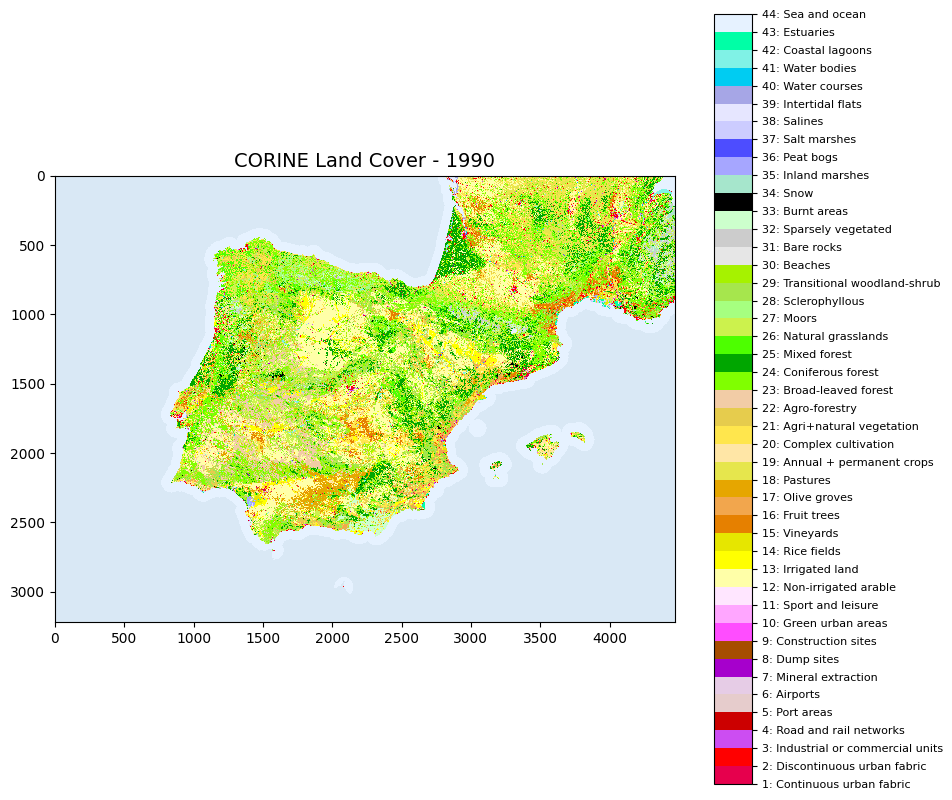

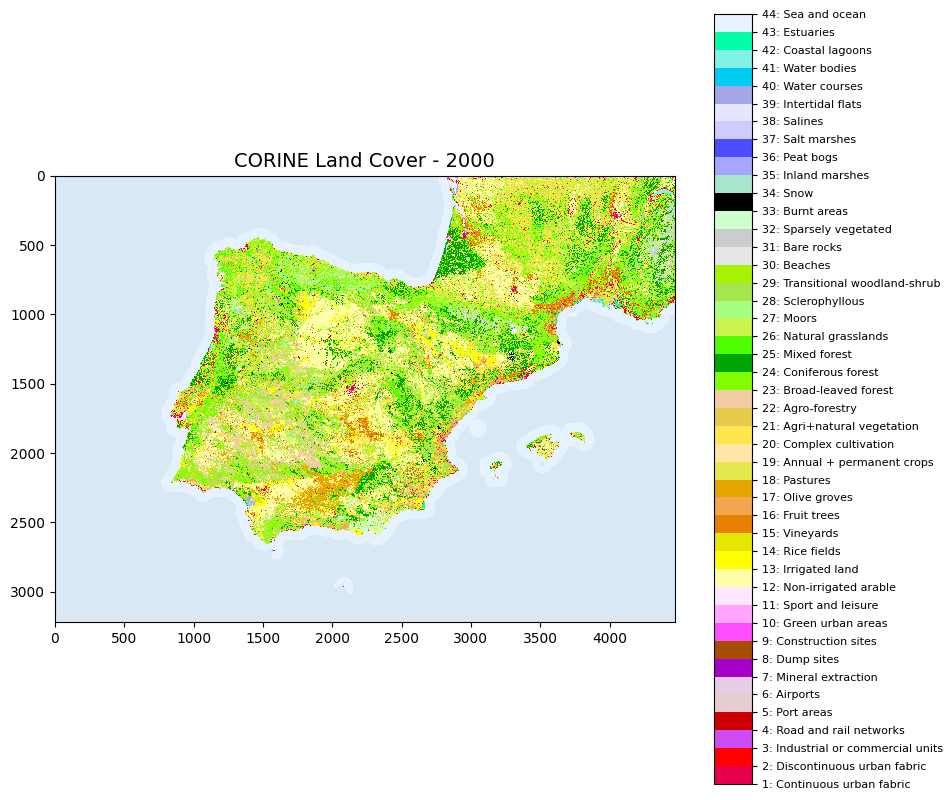

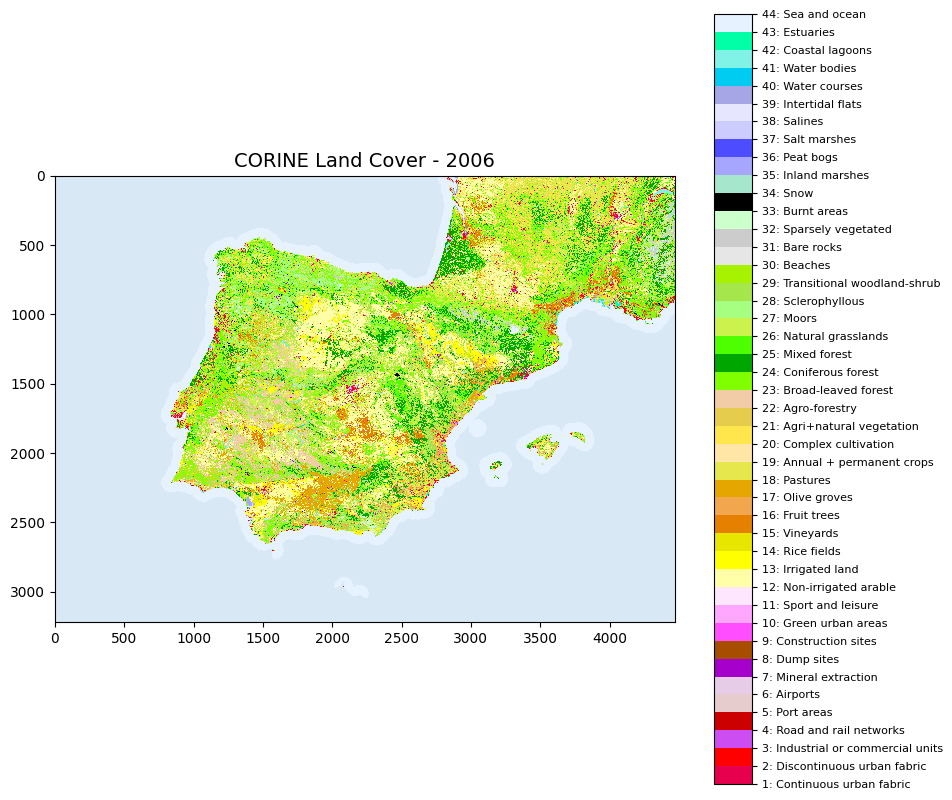

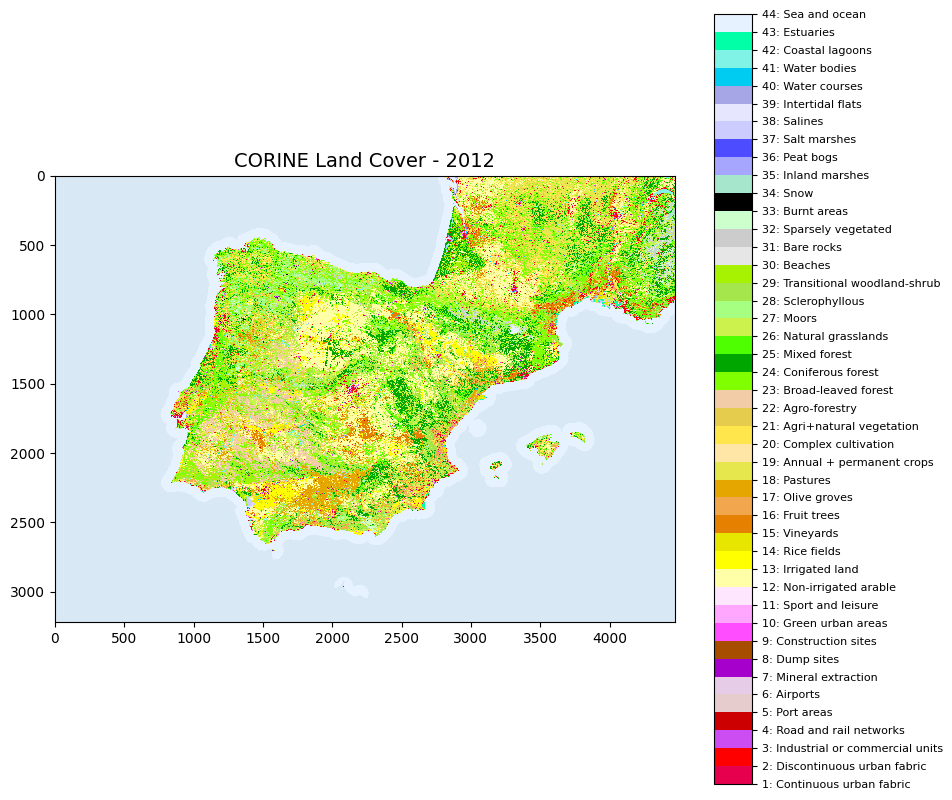

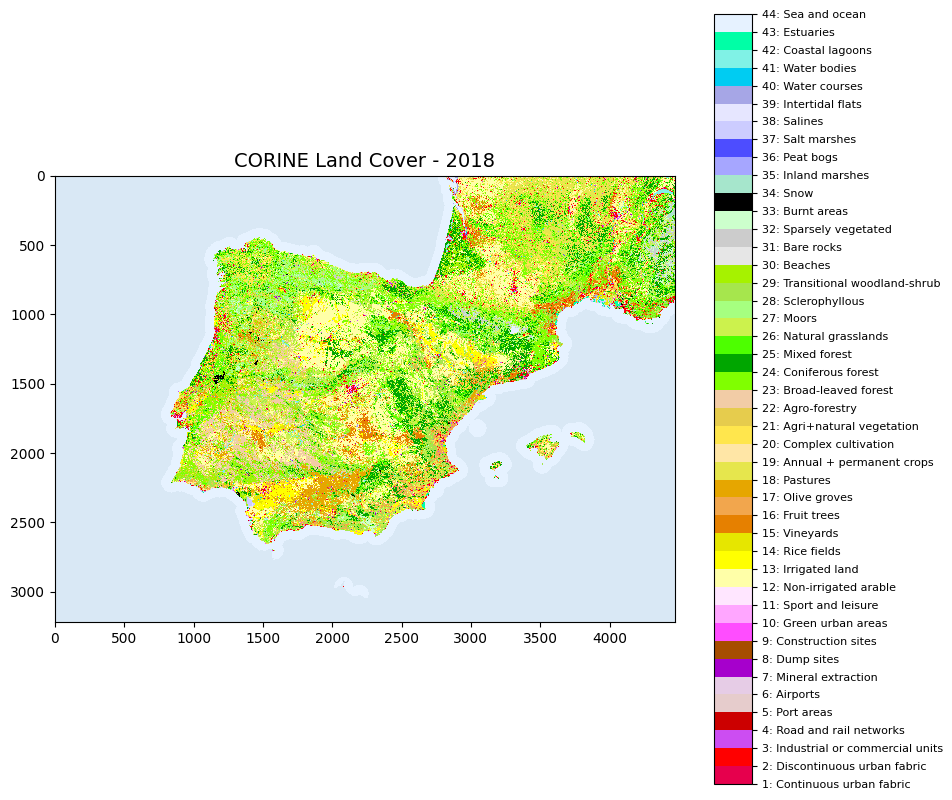

In [ ]:
clc_values = np.array(list(clc_legend.keys()))
clc_colors = np.array(list(clc_legend.values()))

clc_cmap = ListedColormap(clc_colors)
clc_norm = BoundaryNorm(clc_values, clc_cmap.N)

folder_path = processed_data_path+"//CORINE Land Cover Masked"
tif_files = [f for f in os.listdir(folder_path) if f.endswith('.tif')]
years=[1990,2000,2006,2012,2018]
i=0
for tif_file in tif_files:
    tif_path = os.path.join(folder_path, tif_file)
    with rasterio.open(tif_path) as src:
        new_width = src.width // 4
        new_height = src.height // 4
        data_resampled = src.read(1, out_shape=(1, new_height, new_width))
        data_resampled_cleaned = np.where(data_resampled == -128, np.nan, data_resampled)

    cmap = clc_cmap.copy()
    cmap.set_bad(color='#d9e8f5')

    plt.figure(figsize=(10, 10))
    img = plt.imshow(data_resampled_cleaned, cmap=cmap, norm=clc_norm, interpolation='none')

    cbar = plt.colorbar(img, ticks=clc_values)
    cbar.ax.set_yticklabels([f"{code}: {clc_descriptions[code]}"  for code in clc_values])
    cbar.ax.tick_params(labelsize=8)

    plt.title(f"CORINE Land Cover - {years[i]}", fontsize=14)
    plt.savefig(os.path.join(path_png+"Corine images", f"Corine_Land_Cover_{years[i]}.png"), dpi=300)
    plt.show()

    i += 1

Una vez guardadas estas 5 imágenes se monta un archivo .gif con ellas para hacer más evidente y visualizable los cambios en el tipo de suelo en España.

In [ ]:
img_folder = path+"Corine images"
# Ruta final del GIF
gif_path = processed_data_path+"//corine_animacion.gif"

# Listar imágenes PNG ordenadas (por nombre, que debe contener el año)
img_files = sorted([f for f in os.listdir(img_folder) if f.endswith('.png')])

images = []
print("Cargando imágenes para crear GIF:")
for filename in tqdm(img_files):
    img_path = os.path.join(img_folder, filename)
    img = Image.open(img_path)
    images.append(img)

# Crear y guardar el GIF
images[0].save(
    path_html+"corine_animacion.gif",
    format='GIF',
    save_all=True,
    append_images=images[1:],
    duration=1500,  # ms por frame
    loop=0          # loop infinito
)


Cargando imágenes para crear GIF:


100%|██████████| 5/5 [00:00<?, ?it/s]


GIF creado correctamente en: C:\Users\sabel\OneDrive\Escritorio\Master\VD\master-VD\images\corine_animacion.gif


El siguiente bloque de código utiliza estos archivos para agregar una nuva columna en el dataset de incendios. Se genra una comuna `tipo de suelo` que indica el tipo de suelo aproximado en el momento de detección del incendios en el lugar. Es decir, para cada incedios identifica cual es el archivo .tif más cercano temporalmente y busca la clasificación del suelo en el punto exacto para almacenarlo. Este es un proceso muy costoso computacionalmente qu eno se reocmienda volver a ejecutar. Para evitar futuros prublemas se ha guardado en dataset de infenciosampliado con el tipo de suelo en la carpeta processed data con el nombre de `incendios_con_tipo_suelo.csv`. 

In [ ]:

ruta_base = processed_data_path+"//CORINE Land Cover Masked"

# Diccionario año_incendio al raster más cercano
raster_info = {
    1990: ("masked_U2000_CLC1990_V2020_20u1.tif", 1990),
    2000: ("masked_U2006_CLC2000_V2020_20u1.tif", 2000),
    2006: ("masked_U2012_CLC2006_V2020_20u1.tif", 2006),
    2012: ("masked_U2018_CLC2012_V2020_20u1.tif", 2012),
    2018: ("masked_U2018_CLC2018_V2020_20u1.tif", 2018)
}

batch_size = 5000
# Creamos un dataframe
gdf_total = gpd.GeoDataFrame(
    df_incendios.copy(),
    geometry=gpd.points_from_xy(df_incendios.longitud, df_incendios.latitud),
    crs="EPSG:4326"
)

# Esta función sirve para elegir el archivo .tif adecuado dependiendo del año del incendio
def elegir_raster(anio_incendio):
    años_disponibles = np.array(list(raster_info.keys()))
    idx = (np.abs(años_disponibles - anio_incendio)).argmin()
    año_cercano = años_disponibles[idx]
    return raster_info[año_cercano][0], raster_info[año_cercano][1]


df_incendios['tipo_suelo'] = None

#Procesamos los incendios agrupados por lotes
for raster_anio in raster_info.keys():
    raster_file, año_corine = raster_info[raster_anio]
    raster_path = os.path.join(ruta_base, raster_file)

    print(f"\nProcesando raster CORINE {año_corine} para incendios cercanos a ese año...")

    # Filtrar incendios cuyo raster más cercano es este
    mask = df_incendios['anio'].apply(lambda x: elegir_raster(x)[1] == año_corine)
    gdf_anio = gdf_total.loc[mask].copy()
    if gdf_anio.empty:
        print(f"No hay incendios para el raster {año_corine}, saltando...")
        continue

    with rasterio.open(raster_path) as src:
        raster_crs = src.crs
        bounds = src.bounds

    # Reproyectar y filtrar dentro del raster
    gdf_anio = gdf_anio.to_crs(raster_crs)
    dentro_mask = gdf_anio.geometry.apply(lambda g: bounds.left <= g.x <= bounds.right and bounds.bottom <= g.y <= bounds.top)
    gdf_validos = gdf_anio[dentro_mask].copy()

    print(f"Incendios dentro del raster: {len(gdf_validos)}")

    # Procesar por lotes con tqdm
    valores = []
    for i in tqdm(range(0, len(gdf_validos), batch_size), desc=f"Extrayendo tipo de suelo {año_corine}"):
        lote = gdf_validos.iloc[i:i + batch_size]
        vals = point_query(lote.geometry, raster_path)
        valores.extend(vals)
    df_incendios.loc[gdf_validos.index, 'tipo_suelo'] = valores

    # Impresiones de comprobación
    print(f"Primeros 5 tipos de suelo asignados para incendios con raster {año_corine}:")
    muestra = df_incendios.loc[gdf_validos.index, ['provincia', 'tipo_suelo']].head(5)
    print(muestra)

print("\n¡Proceso completo! La columna 'tipo_suelo' está actualizada.")



Procesando raster CORINE 1990 para incendios cercanos a ese año...
Incendios dentro del raster: 237123


Extrayendo tipo de suelo 1990: 100%|██████████| 48/48 [1:04:28<00:00, 80.59s/it] 


Primeros 5 tipos de suelo asignados para incendios con raster 1990:
     provincia tipo_suelo
3752  albacete       12.0
3753  albacete       12.0
3754  albacete       12.0
3755  albacete       12.0
3756  albacete       12.0

Procesando raster CORINE 2000 para incendios cercanos a ese año...
Incendios dentro del raster: 159579


Extrayendo tipo de suelo 2000: 100%|██████████| 32/32 [35:02<00:00, 65.72s/it]


Primeros 5 tipos de suelo asignados para incendios con raster 2000:
       provincia tipo_suelo
242312     alava       18.0
242313     alava        1.0
242314     alava        1.0
242315     alava       18.0
242316     alava       18.0

Procesando raster CORINE 2006 para incendios cercanos a ese año...
Incendios dentro del raster: 100657


Extrayendo tipo de suelo 2006: 100%|██████████| 21/21 [21:13<00:00, 60.63s/it]


Primeros 5 tipos de suelo asignados para incendios con raster 2006:
       provincia tipo_suelo
402382     alava        2.0
402383     alava   6.099144
402384     alava   7.227941
402385     alava        2.0
402386     alava        2.0

Procesando raster CORINE 2012 para incendios cercanos a ese año...
Incendios dentro del raster: 75949


Extrayendo tipo de suelo 2012: 100%|██████████| 16/16 [16:06<00:00, 60.43s/it]


Primeros 5 tipos de suelo asignados para incendios con raster 2012:
       provincia tipo_suelo
503838     alava        2.0
503839     alava        2.0
503840     alava       20.0
503841     alava        2.0
503842     alava       12.0

Procesando raster CORINE 2018 para incendios cercanos a ese año...
Incendios dentro del raster: 8684


Extrayendo tipo de suelo 2018: 100%|██████████| 2/2 [01:51<00:00, 55.79s/it]

Primeros 5 tipos de suelo asignados para incendios con raster 2018:
        provincia tipo_suelo
0  islas baleares        2.0
1          huesca       18.0
2          huesca        1.0
3          huesca   2.306458
4          huesca        2.0

¡Proceso completo! La columna 'tipo_suelo' está actualizada.


In [ ]:
df_incendios.to_csv(processed_data_path+"//incendios_con_tipo_suelo.csv", index=False)

In [ ]:
df_incendios=pd.read_csv(processed_data_path+"incendios_con_tipo_suelo.csv")

Una vez configurada esta nueva columna sse plante observar la distribución de los tipos de suelo en los que se inician los incendios. Sin embargo, para mejorar la interpretabilidad se decide crear grupos temáticos que contengan mas de un tipo de suelo. Se genra una nueva columna en el dataframe de incendios `tipo_suelo`.

In [98]:
grupo_suelo = {
    'Áreas urbanas': list(range(1, 12)), #rosa
    'Tierras de cultivo': list(range(12, 23)), #amarillo
    'Bosques frondosos': [23], #verde oscuro
    'Bosques de coníferas': [24], # verde añulado
    'Bosques mixtos': [25], #verde claro
    'Vegetación natural': [26, 27, 28, 29], #verde
    'Zonas desprovistas': [30, 31, 32, 33], #gris
    'Humedales': [35, 36, 37, 38, 39], #azul
    'Medios acuáticos interiores': [40, 41],#azul oscuro
    'Zonas costeras marinas': [42, 43, 44] #azul claro
}


def clasificar_grupo(codigo):
    for grupo, codigos in grupo_suelo.items():
        if codigo in codigos:
            return grupo
    return "Otro"
df_incendios['grupo_suelo'] = df_incendios['tipo_suelo'].apply(clasificar_grupo)
df_incendios['grupo_suelo']

0              Áreas urbanas
1         Tierras de cultivo
2              Áreas urbanas
3                       Otro
4              Áreas urbanas
                 ...        
585394         Áreas urbanas
585395    Tierras de cultivo
585396         Áreas urbanas
585397                  Otro
585398                  Otro
Name: grupo_suelo, Length: 585399, dtype: object

En el siguiente bloque, utilizando una gama cromática coherente con los colores utilizados en los mapas, se diseña una gráfica de tarta que muestre la distribución de esta variable `grupo suelo` a lo largo de todos lo incendios registrados.

In [ ]:
colores_grupo_suelo = {
    'Áreas urbanas': '#e78ac3',               # rosa
    'Tierras de cultivo': '#ffd92f',          # amarillo
    'Bosques frondosos': '#1b7837',           # verde oscuro
    'Bosques de coníferas': '#5ab4ac',        # verde añulado
    'Bosques mixtos': '#a6dba0',              # verde claro
    'Vegetación natural': '#4daf4a',          # verde
    'Zonas desprovistas': '#999999',          # gris oscuro
    'Humedales': '#80b1d3',                   # azul
    'Medios acuáticos interiores': '#0571b0', # azul oscuro
    'Zonas costeras marinas': '#92c5de',      # azul claro
    'Otros': '#cccccc'                        # gris claro
}

grupos_validos = set(colores_grupo_suelo.keys()) - {"Otros"}

# Separar los datos válidos y los que irán a 'Otros'
df_validos = df_grupo[df_grupo['grupo_suelo'].isin(grupos_validos)].copy()
df_otros = df_grupo[~df_grupo['grupo_suelo'].isin(grupos_validos)].copy()

# Agregar fila 'Otros' si hay datos fuera de los grupos
if not df_otros.empty:
    total_otros = df_otros['num_incendios'].sum()
    total_general = df_validos['num_incendios'].sum() + total_otros
    porcentaje_otros = (total_otros / total_general) * 100

    fila_otros = pd.DataFrame({
        'grupo_suelo': ['Otros'],
        'num_incendios': [total_otros],
        'porcentaje': [porcentaje_otros]
    })

    # Recalcular porcentajes de los válidos
    df_validos['porcentaje'] = (df_validos['num_incendios'] / total_general) * 100

    # Combinar válidos y 'Otros'
    df_grupo_final = pd.concat([df_validos, fila_otros], ignore_index=True)
else:
    df_grupo_final = df_validos.copy()

# Crear selección de hover
highlight = alt.selection_point(
    on="mouseover",
    fields=["grupo_suelo"],
    clear="mouseout"
)

# Gráfico actualizado
tipo_suelo_pie = alt.Chart(df_grupo_final).mark_arc(innerRadius=50).encode(
    theta=alt.Theta("num_incendios:Q", title=""),
    color=alt.Color("grupo_suelo:N",
                    title="Grupo de Suelo",
                    scale=alt.Scale(
                        domain=list(colores_grupo_suelo.keys()),
                        range=list(colores_grupo_suelo.values())
                    )),
    opacity=alt.condition(highlight, alt.value(1), alt.value(0.4)),
    tooltip=[
        alt.Tooltip("grupo_suelo:N", title="Grupo de Suelo"),
        alt.Tooltip("num_incendios:Q", title="Nº de Incendios"),
        alt.Tooltip("porcentaje:Q", title="% del Total", format=".2f")
    ]
).add_params(
    highlight
).properties(
    title="Distribución de Incendios por Grupo de Suelo (con categoría 'Otros')",
    width=500,
    height=400
)

# Mostrar y guardar
tipo_suelo_pie.display()
tipo_suelo_pie.save(path_png + "tipo_suelo_pie.png", scale=2)
tipo_suelo_pie.save(path_html + "tipo_suelo_pie.html")


alt.Chart(...)

### Clima

En estas sección graficamos los datos climáticos. Para ello, devido a que se busca realizar un mapa de calor que muestre temperatatira y precitación es necesario crear una nueva varaible con el nombre de las provincias gramaticalmente correcto. Esto permitirá utilizrse de clave para compararse con el documento GeoJson que contine las siluetas provinciales.

In [ ]:
clima_df=pd.read_csv(processed_data_path+"//dataClima.csv")

# Diccionario para mapear nombres del CSV a nombres "GeoJSON normalizados"
mapping_provincias = {
    "alava": "Álava",
    "albacete": "Albacete",
    "alicante": "Alicante",
    "almeria": "Almería",
    "asturias": "Asturias",
    "avila": "Ávila",
    "badajoz": "Badajoz",
    "barcelona": "Barcelona",
    "burgos": "Burgos",
    "caceres": "Cáceres",
    "cadiz": "Cádiz",
    "cantabria": "Cantabria",
    "castellon": "Castellón",
    "ceuta": "Ceuta",
    "ciudad real": "Ciudad Real",
    "cordoba": "Córdoba",
    "cuenca": "Cuenca",
    "gerona": "Gerona",
    "granada": "Granada",
    "guadalajara": "Guadalajara",
    "guipuzcoa": "Guipúzcoa",
    "huelva": "Huelva",
    "huesca": "Huesca",
    "islas baleares": "Islas Baleares",
    "jaen": "Jaén",
    "la coruna": "La Coruña",
    "la rioja": "La Rioja",
    "las palmas": "Las Palmas",
    "leon": "León",
    "lerida": "Lleida",
    "lugo": "Lugo",
    "madrid": "Madrid",
    "malaga": "Málaga",
    "melilla": "Melilla",
    "murcia": "Murcia",
    "navarra": "Navarra",
    "orense": "Orense",
    "palencia": "Palencia",
    "pontevedra": "Pontevedra",
    "salamanca": "Salamanca",
    "santa cruz de tenerife": "Santa Cruz de Tenerife",
    "segovia": "Segovia",
    "sevilla": "Sevilla",
    "soria": "Soria",
    "tarragona": "Tarragona",
    "teruel": "Teruel",
    "toledo": "Toledo",
    "valencia": "Valencia",
    "valladolid": "Valladolid",
    "vizcaya": "Vizcaya",
    "zamora": "Zamora",
    "zaragoza": "Zaragoza"
}

# Función para normalizar (minúsculas y quitar tildes) los nombres del GeoJSON para comparar
def normalize_name(name):
    return unidecode.unidecode(name).lower()

# Añadir columna en clima_df con nombres de provincias normalizados y coincidentes
clima_df['provincia_name'] = clima_df['provincia'].map(mapping_provincias)

# Comprobar qué filas no se han mapeado (devuelven NaN)
no_mapeados = clima_df[clima_df['provincia_name'].isna()]['provincia'].unique()
print("Provincias no mapeadas:", no_mapeados)
print(clima_df['provincia_name'])

Provincias no mapeadas: []
0            Álava
1         Albacete
2         Alicante
3          Almería
4         Asturias
            ...   
930691     Vizcaya
930692      Zamora
930693    Zaragoza
930694       Ceuta
930695     Melilla
Name: provincia_name, Length: 930696, dtype: object


Una vez realizada esta modificación ya es posible graficar ambos mapas conteniendo la temperatura media diaria por provicnia y la precipitación media diaria por provincia.

In [5]:
temp_media_provincia = clima_df.groupby("provincia_name")["temperatura_media"].mean().reset_index()
temp_media_provincia.columns = ["provincia_name", "temp_media"]
url = "https://gist.githubusercontent.com/josemamira/3af52a4698d42b3f676fbc23f807a605/raw/provincias_spain.geojson"
with urllib.request.urlopen(url) as response:
    provincias_geojson = json.load(response)
provincias_excluir = ['las palmas', 'santa cruz de tenerife']

# Filtrar las provincias del GeoJSON
provincias_geojson['features'] = [
    f for f in provincias_geojson['features']
    if f['properties']['Texto'].lower().strip() not in provincias_excluir
]

# Normalizar nombres en GeoJSON a minúsculas para hacer el lookup (clave 'Texto')
for feature in provincias_geojson['features']:
    feature['properties']['Texto'] = feature['properties']['Texto'].lower().strip()
alt.data_transformers.disable_max_rows()

## Creamos el mapa por provincias
mapa_temp = alt.Chart(alt.Data(values=provincias_geojson['features'])).mark_geoshape().encode(
color=alt.Color('temp_media:Q',
    scale=alt.Scale(
        domain=[temp_media_provincia['temp_media'].min(), temp_media_provincia['temp_media'].max()],
        range=['#ffffcc', '#ffeda0', '#feb24c', '#fd8d3c', '#f03b20', '#bd0026']  # de amarillo a naranja oscuro para temperaturas más altas
    ),
    legend=alt.Legend(title="Temperatura Media (°C)")
)
).transform_lookup(
    lookup='properties.Texto',
    from_=alt.LookupData(temp_media_provincia.assign(provincia_name=temp_media_provincia['provincia_name'].str.lower()), 'provincia_name', ['temp_media'])
).project(
    type='mercator'
).properties(
    width=600,
    height=800,
    title='Temperatura Media Anual por Provincia (Promedio total)'
).configure_view(
    stroke=None
)
mapa_temp.display()
# mapa_temp.save(path_png+"mapa_temp.png", scale=2)

alt.Chart(...)

En segundo lugar se realiza el mismo proceso para crear el mapa con información de las precipitaciones.

In [7]:
precipitacion_media_provincia = clima_df.groupby("provincia_name")["precipitacion"].mean().reset_index()
precipitacion_media_provincia.columns = ["provincia_name", "precipitacion_media"]
url = "https://gist.githubusercontent.com/josemamira/3af52a4698d42b3f676fbc23f807a605/raw/provincias_spain.geojson"
with urllib.request.urlopen(url) as response:
    provincias_geojson = json.load(response)
provincias_excluir = ['las palmas', 'santa cruz de tenerife']

# Filtrar las provincias del GeoJSON
provincias_geojson['features'] = [
    f for f in provincias_geojson['features']
    if f['properties']['Texto'].lower().strip() not in provincias_excluir
]

# Normalizar nombres en GeoJSON a minúsculas para hacer el lookup (clave 'Texto')
for feature in provincias_geojson['features']:
    feature['properties']['Texto'] = feature['properties']['Texto'].lower().strip()
alt.data_transformers.disable_max_rows()

## Creamos el mapa por provincias
mapa_prec = alt.Chart(alt.Data(values=provincias_geojson['features'])).mark_geoshape().encode(
color=alt.Color('precipitacion_media:Q',
    scale=alt.Scale(
        domain=[precipitacion_media_provincia['precipitacion_media'].min(), precipitacion_media_provincia['precipitacion_media'].max()],
        range=['#f7fbff', '#deebf7', '#9ecae1', '#6baed6', '#3182bd', '#08519c']  # de amarillo a naranja oscuro para temperaturas más altas
    ),
    legend=alt.Legend(title="Precipitación Media (mm)")
)
).transform_lookup(
    lookup='properties.Texto',
    from_=alt.LookupData(precipitacion_media_provincia.assign(provincia_name=precipitacion_media_provincia['provincia_name'].str.lower()), 'provincia_name', ['precipitacion_media'])
).project(
    type='mercator'
).properties(
    width=600,
    height=800,
    title='Precipitación Media Anual por Provincia (Promedio total)'
).configure_view(
    stroke=None
)
mapa_prec.display()
# mapa_prec.save(path_png+"mapa_prec.png", scale=2)

alt.Chart(...)

Ahora se realizan las gráficas que comparan el total de incendios mensual con la humedad y precipitaciones medias en esos meses. Para ello promer oes necesario hacer un cambio en el atributo mes que pase a ser numérico.

In [25]:
clima_df['mes']=clima_df['fecha'].apply(lambda x: x.split('-')[1])
clima_df['mes']
# Diccionario para traducir los meses de inglés a español
meses_trad = {1: 'enero', 2: 'febrero', 3: 'marzo', 4: 'abril', 5: 'mayo',
              6: 'junio', 7: 'julio', 8: 'agosto', 9: 'septiembre',
              10: 'octubre', 11: 'noviembre', 12: 'diciembre'}


# Aplicar la traducción a la columna 'mes'
clima_df['mes'] = clima_df['mes'].astype(int)
clima_df['mes'] = clima_df['mes'].map(meses_trad)
clima_df['mes']

0             enero
1             enero
2             enero
3             enero
4             enero
            ...    
930691    diciembre
930692    diciembre
930693    diciembre
930694    diciembre
930695    diciembre
Name: mes, Length: 930696, dtype: object

En el sigueitne bloque se grafican las figuras de las que hemos hablado, comparando la ocurrencia mensual de incendios con la humedad y precipitaciones medias en ese tiempo.

In [ ]:
df_mensual = df_incendios.groupby('mesdeteccion').size().reset_index(name='num_incendios')

# Agrupar clima: media mensual de precipitación total por provincia y mes
precipitacion_mensual = (
    clima_df.groupby('mes')['precipitacion']
    .mean()
    .reset_index(name='precipitacion_media')
)

# Unificar con df_mensual
df_combined = pd.merge(df_mensual, precipitacion_mensual, left_on='mesdeteccion', right_on='mes')
min_prec = df_combined['precipitacion_media'].min()
max_prec = df_combined['precipitacion_media'].max()

# Orden cronológico de los meses
orden_meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio',
               'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']

# Crear gráfico de barras para incendios
barras = alt.Chart(df_combined).mark_bar().encode(
    x=alt.X('mesdeteccion:N', sort=orden_meses, axis=alt.Axis(title='Mes')),
    y=alt.Y('num_incendios:Q', axis=alt.Axis(title='Número de Incendios')),
    color=alt.Color('num_incendios:Q',
                    scale=alt.Scale(domain=[df_combined['num_incendios'].min(),
                                            df_combined['num_incendios'].max()],
                                    range=['#f2f2f2', '#ff3300']),
                    legend=alt.Legend(title='Número de Incendios')),
    tooltip=['mesdeteccion', 'num_incendios']
)

# Crear línea para precipitación media
linea = alt.Chart(df_combined).mark_line(point=True, color='steelblue', strokeWidth=2).encode(
    x=alt.X('mesdeteccion:N', sort=orden_meses),
        y=alt.Y('precipitacion_media:Q',
            scale=alt.Scale(domain=[min_prec*(0.999),max_prec*(1.001)]), 
            axis=alt.Axis(title='Precipitación Media (mm)', titleColor='steelblue')),
    tooltip=['mes', 'precipitacion_media']
)

# Combinar ambos gráficos
prec_mensual = alt.layer(barras, linea).resolve_scale(
    y='independent'  
).properties(
    title='Incendios mensuales y precipitación media por mes',
    width=650,
    height=400
)

prec_mensual.display()
# prec_mensual.save(path_png+"prec_mensual.png", scale=2)

alt.LayerChart(...)

In [ ]:

df_mensual = df_incendios.groupby('mesdeteccion').size().reset_index(name='num_incendios')

# Agrupar clima: media mensual de precipitación total por provincia y mes
precipitacion_mensual = (
    clima_df.groupby('mes')['humedad']
    .mean()
    .reset_index(name='humedad_media')
)

# Unificar con df_mensual
df_combined = pd.merge(df_mensual, precipitacion_mensual, left_on='mesdeteccion', right_on='mes')
min_prec = df_combined['humedad_media'].min()
max_prec = df_combined['humedad_media'].max()

# Orden cronológico de los meses
orden_meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio',
               'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']

# Crear gráfico de barras para incendios
barras = alt.Chart(df_combined).mark_bar().encode(
    x=alt.X('mesdeteccion:N', sort=orden_meses, axis=alt.Axis(title='Mes')),
    y=alt.Y('num_incendios:Q', axis=alt.Axis(title='Número de Incendios')),
    color=alt.Color('num_incendios:Q',
                    scale=alt.Scale(domain=[df_combined['num_incendios'].min(),
                                            df_combined['num_incendios'].max()],
                                    range=['#f2f2f2', '#ff3300']),
                    legend=alt.Legend(title='Número de Incendios')),
    tooltip=['mesdeteccion', 'num_incendios']
)

# Crear línea para precipitación media
linea = alt.Chart(df_combined).mark_line(point=True, color='green', strokeWidth=2).encode(
    x=alt.X('mesdeteccion:N', sort=orden_meses),
        y=alt.Y('humedad_media:Q',
            scale=alt.Scale(domain=[min_prec*(0.999),max_prec*(1.001)]),  
            axis=alt.Axis(title='Humedad Media (%)', titleColor='green')),
    tooltip=['mes', 'humedad_media']
)

# Combinar ambos gráficos
hum_mensual = alt.layer(barras, linea).resolve_scale(
    y='independent'  
).properties(
    title='Incendios mensuales y humedad media por mes',
    width=650,
    height=400
)

hum_mensual.display()
hum_mensual.save(path_png+"hum_mensual.png", scale=2)


alt.LayerChart(...)

NameError: name 'path_png' is not defined

### población

En esta sección se grafican las visualizaciones relativas a dos datos demograficos en comparación con los incendios. Para ello, en primer lugar se crea la categoría 

In [ ]:

df_poblacion = pd.read_csv(processed_data_path+"//dataDemografica_processed.csv", sep=';')
df_poblacion

Provincias  Periodo   Total   categoria
0     02 albacete     2016  392118  semiurbana
1     02 albacete     2015  394580  semiurbana
2     02 albacete     2014  396987  semiurbana
3     02 albacete     2013  400007  semiurbana
4     02 albacete     2012  402837  semiurbana
...           ...      ...     ...         ...
1035   52 melilla     2001   68789       rural
1036   52 melilla     2000   66263       rural
1037   52 melilla     1999   56929       rural
1038   52 melilla     1998   60108       rural
1039   52 melilla     1996   59576       rural

[1040 rows x 4 columns]

El siguiente cóigo grafica el total de incedios por años de las tres clases. De esta forma se dibujan tres línas que simbolizan la evolución, respectivametne, de los incendios en provicnias rurales, semiurbanas y urbanas.

In [ ]:
df_incendios_pob = df_incendios[df_incendios['anio'] >= 1996].copy()

# Limpiar nombres provincia (en df_incendios_pob)
df_incendios_pob.loc[:, 'provincia'] = df_incendios_pob['provincia'].str.lower().str.strip()


# Limpiar df_poblacion (provincias) con función custom
import re

def clean_provincia(nombre):
    nombre = re.sub(r'^\d+\s*', '', nombre)
    nombre = nombre.lower().strip()
    nombre = nombre.replace('alicante/alacant', 'alicante')
    nombre = nombre.replace('balears, illes', 'islas baleares')
    nombre = nombre.replace('coruna, a', 'a coruna')
    nombre = nombre.replace('rioja, la', 'la rioja')
    nombre = nombre.replace('valencia/valencia', 'valencia')
    return nombre

df_poblacion.loc[:, 'provincia'] = df_poblacion['Provincias'].apply(clean_provincia)

# Seleccionar solo columnas relevantes para merge
df_cat = df_poblacion.rename(columns={'Periodo':'anio'})[['provincia', 'anio', 'categoria']]
df_incendios_pob = df_incendios_pob.loc[:, ~df_incendios_pob.columns.duplicated()]
incendios_cat = pd.merge(df_incendios_pob, df_cat, on=['provincia', 'anio'], how='left')


# Hacemos merge por provincia y año para asignar categoría a cada incendio
incendios_cat = pd.merge(df_incendios_pob, df_cat, on=['provincia', 'anio'], how='left')

# Agrupar por año y categoría para contar incendios
incendios_agrupados = incendios_cat.groupby(['anio', 'categoria']).size().reset_index(name='cantidad_incendios')
todos_anios = pd.DataFrame({'anio': sorted(incendios_agrupados['anio'].unique())})
categorias = ['rural', 'semiurbana', 'urbana']
todos_combinados = pd.MultiIndex.from_product([todos_anios['anio'], categorias], names=['anio', 'categoria']).to_frame(index=False)

incendios_agrupados_completo = pd.merge(todos_combinados, incendios_agrupados, on=['anio', 'categoria'], how='left').fillna(0)

# Gráfica Altair
alt.data_transformers.disable_max_rows()

zonas_evol = alt.Chart(incendios_agrupados_completo).mark_line(point=True).encode(
    x=alt.X('anio:O', title='Año'),
    y=alt.Y('cantidad_incendios:Q', title='Cantidad de incendios'),
    color=alt.Color('categoria:N', title='Categoría Provincia',
                    scale=alt.Scale(domain=categorias, range=['#da3191', '#ffdb35','#34adae']))
).properties(
    width=700,
    height=400,
    title='Evolución anual de incendios según categoría de provincia'
).interactive()

zonas_evol.display()
zonas_evol.save(path_png+"zonas_evol.png", scale=2)
zonas_evol.save(path_html+"zonas_evol.html")


alt.Chart(...)

NameError: name 'path_png' is not defined

Por último, se grafica la distribución de los incendios en relación a los tipos de provincia.

In [32]:
# Contar total incendios por categoría
incendios_totales_categoria = incendios_cat['categoria'].value_counts().reset_index()
incendios_totales_categoria.columns = ['categoria', 'cantidad_incendios']

# Crear gráfico de tarta con Altair
pie_zonas = alt.Chart(incendios_totales_categoria).mark_arc().encode(
    theta=alt.Theta(field='cantidad_incendios', type='quantitative'),
    color=alt.Color(field='categoria', type='nominal',
                    scale=alt.Scale(domain=['rural', 'semiurbana', 'urbana'],
                                     range=['#da3191', '#ffdb35','#34adae'])),
    tooltip=['categoria', 'cantidad_incendios']
).properties(
    title='Distribución total de incendios por categoría de provincia',
    width=400,
    height=400
)

pie_zonas.display()
pie_zonas.save(path_png+"pie_zonas.png", scale=2)
pie_zonas.save(path_html+"pie_zonas.html")

alt.Chart(...)

NameError: name 'path_png' is not defined

### Emisiones

Para la visualización de los gases de emisiones se deciden hacer dos gráficas:

1.  **Gráfica de dispersión** entre los incendios anuales y las emisioens de gases de efecto invernader.
2.  **Gráfico de barras** de las emisiones, separadas por tipo de emisión, anualmente.

La motivación de este tipo de gráficas está explicada en la memoria adjunta.

In [ ]:
df_ems = pd.read_csv(processed_data_path+"//emisionesFAOSTAT.csv")')
df_co2_grouped_sum = df_ems.groupby(['Year', 'Element'], as_index=False)['Value'].sum()

selector = alt.selection_single(
    fields=['Element'],
    bind=alt.binding_select(options=sorted(df_co2_grouped_sum['Element'].unique())),
    name='Tipo de Emisión'
)

evol_ems = alt.Chart(df_co2_grouped_sum).mark_bar().encode(
    x=alt.X('Year:O', title='Año'),
    y=alt.Y('Value:Q', title='Emisiones'),
    color=alt.Color('Element:N', title='Tipo de Emisión'),
    tooltip=['Year', 'Element', 'Value'],
    opacity=alt.condition(selector, alt.value(1), alt.value(0.2)) 
).add_selection(
    selector
).properties(
    title="Contribución de las emisiones por tipo a lo largo de los años",
    width=700,
    height=400
)

evol_ems.show()
evol_ems.save(path_html+"evol_ems.html")


C:\Users\sabel\AppData\Local\Temp\ipykernel_6912\109590117.py:4: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use selection_point instead.
  selector = alt.selection_single(
C:\Users\sabel\AppData\Local\Temp\ipykernel_6912\109590117.py:10: AltairDeprecationWarning: 
Deprecated since `altair=5.0.0`. Use add_params instead.
  evol_ems = alt.Chart(df_co2_grouped_sum).mark_bar().encode(


alt.Chart(...)

In [ ]:

#Total anual de incendios
df_inc_anual = df_incendios.groupby('anio').size().reset_index(name='total_incendios')
df_ems_total = df_ems.groupby('Year').agg({'Value': 'sum'}).reset_index()
df_ems_total.rename(columns={'Year': 'anio', 'Value': 'total_emisiones'}, inplace=True)

# Unimos ambos DataFrames por año
df_union = pd.merge(df_inc_anual, df_ems_total, on='anio', how='inner')

# Gráfico de dispersión
disp_emisiones = alt.Chart(df_union).mark_circle(size=60).encode(
    x=alt.X('total_incendios:Q', title='Total Incendios Anuales'),
    y=alt.Y('total_emisiones:Q', title='Total Emisiones Anuales'),
    tooltip=['anio', 'total_incendios', 'total_emisiones'],
    color=alt.value('green')
).properties(
    title='Relación entre Incendios Anuales y Emisiones Anuales',
    width=600,
    height=400
)

disp_emisiones.display()

disp_emisiones.save(path_png+"disp_emisiones.png", scale=2)

alt.Chart(...)